# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Подготовка

In [ ]:
# Импортируем библиотеки

import pandas as pd

import numpy as np

import seaborn as sns

import re

from nltk.corpus import stopwords 

import nltk

from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score, confusion_matrix, classification_report

from sklearn.dummy import DummyClassifier

In [ ]:
# прочитаем данные 

def data_reading(path):
    data = pd.read_csv(path)
    print(f'Информация о данных: \n')
    data.info()
    print(f'\nКоличество дубликатов: {data.duplicated().sum()} \n')
    print(f'\nДоля дубликатов: {data.duplicated().mean()}\n')
    print(f'\nКоличество пропусков:\n\
{data.isna().sum()} \n')
    print(f'\nДоля пропусков:\n\
{data.isna().mean()} \n')
    print(f'Первые 5 строк датасета: \n')
    display(data.head(5))
    return data

In [ ]:
data = data_reading('/content/toxic_comments.csv')

Информация о данных: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB

Количество дубликатов: 0 


Доля дубликатов: 0.0


Количество пропусков:
Unnamed: 0    0
text          0
toxic         0
dtype: int64 


Доля пропусков:
Unnamed: 0    0.0
text          0.0
toxic         0.0
dtype: float64 

Первые 5 строк датасета: 



,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
# оценим соотношение классов в целевом признаке
data['toxic'].value_counts(normalize = True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

Пропусков нет и все строки уникальны.

Наблюдается дисбаланс классов (примерно каждый 10-й комментарий - *toxic*)

In [ ]:
# с помощью регулярных выражений избавим твиты от лишних символов
# создадим функцию, которая возвращает с нижним регистром, а имеющиеся символы заменит на пробелы

def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]+', ' ', text)
    return text.strip().lower().split()

In [ ]:
# для наглядности будем добавлять столбец, содержащий измененный текст после каждой манипуляции

data['clear_symbol'] = data['text'].apply(clear_text)

# оценим получившиеся результаты

data.head()

,Unnamed: 0,text,toxic,clear_symbol
0,0,Explanation\nWhy the edits made under my usern...,0,"[explanation, why, the, edits, made, under, my..."
1,1,D'aww! He matches this background colour I'm s...,0,"[d, aww, he, matches, this, background, colour..."
2,2,"Hey man, I'm really not trying to edit war. It...",0,"[hey, man, i, m, really, not, trying, to, edit..."
3,3,"""\nMore\nI can't make any real suggestions on ...",0,"[more, i, can, t, make, any, real, suggestions..."
4,4,"You, sir, are my hero. Any chance you remember...",0,"[you, sir, are, my, hero, any, chance, you, re..."


In [ ]:
# выгрузим стоп-слова (нас интересуют английские стоп-слова, так как твиты написаны на английском языке)

nltk.download('stopwords') 
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# проведем чистку стоп-слов и лемматизацию 

lemmatizer = nltk.WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')

def lemmatize_text(text):
    text = [word for word in text if word not in stop_words]
    text = [lemmatizer.lemmatize(word) for word in text]
    return ' '.join(text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# добавим столбец, куда будем заносить текст после лемматизиции

data['lemm_clean_text'] = data['clear_symbol'].apply(lambda text: lemmatize_text(text))

# оценим получившиеся результаты

data.head()

,Unnamed: 0,text,toxic,clear_symbol,lemm_clean_text
0,0,Explanation\nWhy the edits made under my usern...,0,"[explanation, why, the, edits, made, under, my...",explanation edits made username hardcore metal...
1,1,D'aww! He matches this background colour I'm s...,0,"[d, aww, he, matches, this, background, colour...",aww match background colour seemingly stuck th...
2,2,"Hey man, I'm really not trying to edit war. It...",0,"[hey, man, i, m, really, not, trying, to, edit...",hey man really trying edit war guy constantly ...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,"[more, i, can, t, make, any, real, suggestions...",make real suggestion improvement wondered sect...
4,4,"You, sir, are my hero. Any chance you remember...",0,"[you, sir, are, my, hero, any, chance, you, re...",sir hero chance remember page


Исходный текст подвергся нескольким трансформациям: сведен к нижнему регистру, очищен от знаков, отлемматизирован и "очищен" от стоп-слов.

Результат преобразований находится в столбце **lemm_clean_text**

Далее производится разбиение на признаки, тренировочные и тестовые выборки и преобразование их в дальнейшем в вектора

In [ ]:
# оставим лемматизированный текст и столбец toxic

data = data[['lemm_clean_text', 'toxic']]

In [ ]:
# перед вычислением tf-idf корпуса текста произведем разбиение данных на признаки и целевой признак
# воспользуемся параметром stratify, чтобы сохранить пропорцию классов

features = data.drop('toxic', axis = 1)
target = data['toxic'].values

# разобъем данные на тренировочную и тестовые выборки в пропорции 75 / 25 

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target,
                                                                            test_size = 0.25,
                                                                            random_state=12345,
                                                                            stratify = target) 


                                                                                                                                                 

In [ ]:
# оценим размерности выборок

print(f'Размерность тренировочной выборки: {features_train.shape, target_train.shape}')
print(f'Размерность тестовой выборки: {features_test.shape, target_test.shape}')

Размерность тренировочной выборки: ((119469, 1), (119469,))
Размерность тестовой выборки: ((39823, 1), (39823,))


In [ ]:
# создадим текстовый вектор

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df = 0.8, min_df = 2)

features_train_tfidf = vectorizer.fit_transform(features_train['lemm_clean_text'])
features_test_tfidf = vectorizer.transform(features_test['lemm_clean_text'])

In [ ]:
# оценим размерности векторов-признаков

print(f'Размерность тренировочного текстового вектора: {features_train_tfidf.shape}')
print(f'Размерность тестового текстового вектора: {features_test_tfidf.shape}')

Размерность тренировочного текстового вектора: (119469, 445516)
Размерность тестового текстового вектора: (39823, 445516)


## Обучение

In [ ]:
# логистическая регрессия

parameters = {'C': [0.5,1,5,10,50],
              'solver': ['lbfgs', 'liblinear']}

model_lr = LogisticRegression(random_state = 12345, 
                              class_weight = 'balanced')                             

grid_searching = GridSearchCV(model_lr, 
                              parameters,
                              scoring = 'f1', 
                              cv=5, 
                              n_jobs=-1)

grid_searching.fit(features_train_tfidf, target_train)

print('Лучшие параметры модели:', grid_searching.best_params_)
print('Лучшее значение RMSE:', grid_searching.best_score_)

Лучшие параметры модели: {'C': 10, 'solver': 'liblinear'}
Лучшее значение RMSE: 0.7891250548167472


In [ ]:
# дерево решений

parameters = {'max_depth': range (1, 10, 2), 
              'criterion': ['gini', 'entropy','log_loss'],
              'splitter': ['best', 'random']}

model_dt = DecisionTreeClassifier(random_state = 12345, 
                                  class_weight = 'balanced')

grid_searching = GridSearchCV(model_dt, 
                              parameters,
                              scoring = 'f1',
                              cv=5, 
                              n_jobs=-1)

grid_searching.fit(features_train_tfidf, target_train)

print('Лучшие параметры модели:', grid_searching.best_params_)
print('Лучшее значение RMSE:', grid_searching.best_score_)

Лучшие параметры модели: {'criterion': 'gini', 'max_depth': 9, 'splitter': 'best'}
Лучшее значение RMSE: 0.56163886606767


In [ ]:
# случайный лес

parameters = {'max_depth': range (1, 10, 2), 
              'n_estimators': range(10,51,10),
              'criterion': ['gini', 'entropy','log_loss']}

model_rf = RandomForestClassifier(random_state = 12345, 
                                  class_weight = 'balanced')

grid_searching = GridSearchCV(model_rf, 
                              parameters,
                              scoring = 'f1',
                              cv=5, 
                              n_jobs = -1)

grid_searching.fit(features_train_tfidf, target_train)

print('Лучшие параметры модели:', grid_searching.best_params_)
print('Лучшее значение RMSE:', grid_searching.best_score_)

Лучшие параметры модели: {'criterion': 'gini', 'max_depth': 9, 'n_estimators': 50}
Лучшее значение RMSE: 0.30222674232293184


Для исследования были использованы модели логистической регрессии, случайного леса и дерева решений.

Моделируя на тренировочных выборках, лучшие результаты показала модель логистической регрессии, поэтому выберем эту модель для дальнейшего тестирования

## Выводы

In [ ]:
# применим наилучшие гиперпараметры для логистической модели и найдем f1-метрика на тестовой выборке

model_lr = LogisticRegression(random_state = 12345, 
                              class_weight = 'balanced',
                              C = 10,
                              solver = 'liblinear')

model_lr.fit(features_train_tfidf, target_train)

print(f'f1-метрика для тестовой выборки: {f1_score(target_test, model_lr.predict(features_test_tfidf))}')


f1-метрика для тестовой выборки: 0.7856269860669762


<AxesSubplot:>

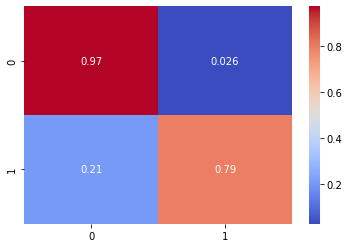

In [ ]:
# для интерпретации результатов воспользуемся матрицей ошибок 
# для ее визуализации применим heatmap

sns.heatmap(confusion_matrix(target_test, model_lr.predict(features_test_tfidf), normalize = 'true'), 
            annot = True, 
            cmap ='coolwarm')

Наглядная интерпретация матрицы ошибок отлично отражает работу нашей модели - теплыми цветами (значения близкие к максимуму) отмечены истинно правдивые и истинно ложные значения (то есть совпадение тестовых целевых признаков с предсказаниями), что говорит о хороших результатах работы нашей модели.

Также стоит отметить, что целевой показатель f1-метрики 0,75 достигнут и для нашей модели на тестовой выборке достигает 0,794 (на тренировочной - 0,786).

In [ ]:
# создаем наивную модель, предсказывающие только самые частые твиты (нетоксичные)

dummy_model = DummyClassifier(strategy = 'most_frequent', random_state=12345)

dummy_model.fit(features_train_tfidf, target_train)

DummyClassifier(random_state=12345, strategy='most_frequent')

In [ ]:
# выведем значения точности ,полноты и f1-метрики для наивной и лучшей моделей

print('Показатели для наивной модели\n', classification_report(dummy_model.predict(features_test_tfidf), target_test))
print('Показатели для лучшей модели\n', classification_report(model_lr.predict(features_test_tfidf), target_test))

Показатели для наивной модели
               precision    recall  f1-score   support

           0       1.00      0.90      0.95     39823
           1       0.00      0.00      0.00         0

    accuracy                           0.90     39823
   macro avg       0.50      0.45      0.47     39823
weighted avg       1.00      0.90      0.95     39823

Показатели для лучшей модели
               precision    recall  f1-score   support

           0       0.97      0.98      0.98     35687
           1       0.79      0.78      0.79      4136

    accuracy                           0.96     39823
   macro avg       0.88      0.88      0.88     39823
weighted avg       0.96      0.96      0.96     39823



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Проверку на адекватность модель также прошла успешно.